<a href="https://colab.research.google.com/github/KarthiK-ctrl-A/BigDataAnalytics/blob/main/HandsOn_SaiKarthikPatri_feb_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real-World Data Processing with RNN, LSTM, and GRU in PyTorch


In [4]:
!pip install yfinance

In [13]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf

# Check if CUDA (GPU support) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download the AAPL stock data from Yahoo Finance for the last 10 days with 1-minute intervals
ticker = '^GSPC'
df = yf.download(ticker, period='8d', interval='1m')

# Select the 'Close' price for modeling
df = df[['Close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(df.values)

# Function to create sequences for RNNs
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        labels.append(data[i+seq_length])
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

seq_length = 30  # Use past 30 minutes to predict the next minute
X, y = create_sequences(data, seq_length)

# Reshape X to match PyTorch format (batch_size, sequence_length, features)
X = X.view(X.shape[0], seq_length, 1)

print(f"Shape of input (X): {X.shape}")
print(f"Shape of labels (y): {y.shape}")


[*********************100%***********************]  1 of 1 completed

Shape of input (X): torch.Size([3076, 30, 1])
Shape of labels (y): torch.Size([3076, 1])


## Define RNN, LSTM, and GRU Models

In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out


## Training the Models and Recording Loss

In [15]:

def train_model(model, X, y, epochs=100, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y.view(-1, 1))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

    return losses

# Initialize models
rnn_model = RNNModel(input_size=1, hidden_size=64, output_size=1)
lstm_model = LSTMModel(input_size=1, hidden_size=64, output_size=1)
gru_model = GRUModel(input_size=1, hidden_size=64, output_size=1)

# Train models and record loss
rnn_losses = train_model(rnn_model, X, y)
lstm_losses = train_model(lstm_model, X, y)
gru_losses = train_model(gru_model, X, y)


Epoch 0, Loss: 0.1032
Epoch 10, Loss: 0.0409
Epoch 20, Loss: 0.0100
Epoch 30, Loss: 0.0053
Epoch 40, Loss: 0.0032
Epoch 50, Loss: 0.0025
Epoch 60, Loss: 0.0022
Epoch 70, Loss: 0.0021
Epoch 80, Loss: 0.0021
Epoch 90, Loss: 0.0021
Epoch 0, Loss: 0.1195
Epoch 10, Loss: 0.0957
Epoch 20, Loss: 0.0677
Epoch 30, Loss: 0.0089
Epoch 40, Loss: 0.0081
Epoch 50, Loss: 0.0052
Epoch 60, Loss: 0.0049
Epoch 70, Loss: 0.0046
Epoch 80, Loss: 0.0043
Epoch 90, Loss: 0.0041
Epoch 0, Loss: 0.1059
Epoch 10, Loss: 0.0709
Epoch 20, Loss: 0.0316
Epoch 30, Loss: 0.0108
Epoch 40, Loss: 0.0046
Epoch 50, Loss: 0.0032
Epoch 60, Loss: 0.0032
Epoch 70, Loss: 0.0030
Epoch 80, Loss: 0.0028
Epoch 90, Loss: 0.0027


## Visualizing the Training Loss

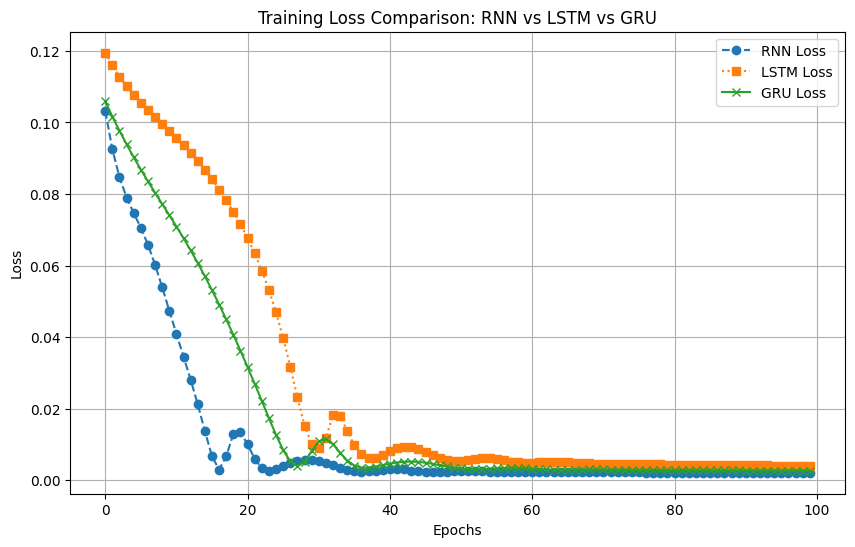

In [16]:

# Plot Training Loss Curves
plt.figure(figsize=(10,6))
plt.plot(rnn_losses, label='RNN Loss', linestyle='dashed', marker='o')
plt.plot(lstm_losses, label='LSTM Loss', linestyle='dotted', marker='s')
plt.plot(gru_losses, label='GRU Loss', linestyle='solid', marker='x')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison: RNN vs LSTM vs GRU')
plt.legend()
plt.grid(True)
plt.show()


## Testing the Models on New Data

In [17]:

def predict(model, input_seq):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).view(1, seq_length, 1)
    with torch.no_grad():
        prediction = model(input_seq)
    return scaler.inverse_transform(prediction.numpy().reshape(-1, 1))[0][0]

# Example Test Case (Predict Next Day's Closing Price)
test_seq = data[-seq_length:].reshape(-1, 1)  # Use the last 30 days
RNNPrediction = predict(rnn_model, test_seq)
LSTMPrediction = predict(lstm_model, test_seq)
GRUPrediction = predict(gru_model, test_seq)
print("RNN Prediction:", RNNPrediction)
print("LSTM Prediction:", LSTMPrediction)
print("GRU Prediction:", GRUPrediction)


RNN Prediction: 6113.438
LSTM Prediction: 6110.598
GRU Prediction: 6113.269


In [18]:
!pip install transformers


In [19]:
from transformers import pipeline

# Initialize the large language model (LLM) for text generation
explainer = pipeline("text-generation", model="HuggingFaceH4/zephyr-7b-alpha", device=0, torch_dtype="auto")  # Example LLM model

# Define the prompts based on your model predictions
prompts = {
    "RNN": f"Explain why the RNN model predicted {RNNPrediction} for the Apple stock price based on the past 30 days.",
    "LSTM": f"Explain why the LSTM model predicted {LSTMPrediction} for the Apple stock price based on the past 30 days.",
    "GRU": f"Explain why the GRU model predicted {GRUPrediction} for the Apple stock price based on the past 30 days.",
}

# Fetch explanations for each prompt
for model_name, prompt in prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{model_name} Prediction Explanation: {explanation[0]['generated_text']}\n")

# Additional Explainability Prompts (Sample)
additional_prompts = {
    "RNN_LSTM_Comparison": "Explain why LSTM performs better than RNN for long-term dependencies in time-series data.",
    "LSTM_GRU_Comparison": "What are the main differences between LSTM and GRU models when predicting stock prices?",
}

# Fetch explanations for model comparisons
for prompt_name, prompt in additional_prompts.items():
    explanation = explainer(prompt, max_length=100)
    print(f"{prompt_name} Explanation: {explanation[0]['generated_text']}\n")


config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


RNN Prediction Explanation: Explain why the RNN model predicted 6113.43798828125 for the Apple stock price based on the past 30 days.

Generate according to: We will be using a Recurrent Neural Network (RNN) to predict the stock price of Apple (AAPL) for the next day based on the past 30 days.

The RNN model is trained on the historical stock prices of

LSTM Prediction Explanation: Explain why the LSTM model predicted 6110.59814453125 for the Apple stock price based on the past 30 days.

Generate according to: The LSTM model predicted 6110.59814453125 for the Apple stock price based on the past 30 days.
The LSTM model predicted 113.5981445

GRU Prediction Explanation: Explain why the GRU model predicted 6113.26904296875 for the Apple stock price based on the past 30 days.
Generate according to: The GRU model is a type of recurrent neural network (RNN) that is specifically designed to handle time series data. It is an acronym for Gated Recurrent Unit, and it is a variant of the Long Sho